In [ ]:
!pip install ts2vec pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from ts2vec import TS2Vec

In [ ]:
df = pd.read_excel("/content/EG_FEC_RNEW.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Goal               271 non-null    int64  
 1   Target             271 non-null    float64
 2   Indicator          271 non-null    object 
 3   SeriesCode         271 non-null    object 
 4   SeriesDescription  271 non-null    object 
 5   GeoAreaCode        271 non-null    int64  
 6   GeoAreaName        271 non-null    object 
 7   Reporting Type     271 non-null    object 
 8   Units              271 non-null    object 
 9   2000               265 non-null    float64
 10  2001               265 non-null    float64
 11  2002               267 non-null    float64
 12  2003               267 non-null    float64
 13  2004               267 non-null    float64
 14  2005               268 non-null    float64
 15  2006               268 non-null    float64
 16  2007               268 non

In [ ]:
import pandas as pd

# --- 1. Pilih 1 indikator dulu (syarat time-series) ---
indicator = df['SeriesCode'].unique()[0]
df_sel = df[df['SeriesCode'] == indicator].copy()

# --- 2. Sort (walaupun tidak wajib, tetap mengikuti struktur aslinya) ---
df_sel = df_sel.sort_values(["GeoAreaName"])

# --- 3. Ambil kolom tahun sebagai "year" ---
year_cols = [str(y) for y in range(2000, 2023)]

# --- 4. Pivot menjadi wide format ---
# index   = negara
# columns = tahun
# values  = nilai indikator
pivot = df_sel.set_index("GeoAreaName")[year_cols]

# --- 5. Interpolasi NA (TS2Vec TIDAK boleh ada NaN) ---
pivot = pivot.astype(float)
pivot = pivot.interpolate(axis=1).fillna(method="bfill", axis=1).fillna(method="ffill", axis=1)

# --- 6. Convert ke numpy wide format ---
# pivot: (num_countries, seq_len)
data = pivot.values

# --- 7. Reshape ke format TS2Vec: (N, T, 1) ---
data = data[:, :, None]

print("Shape data:", data.shape)

Shape data: (271, 23, 1)


/tmp/ipython-input-711299474.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.interpolate(axis=1).fillna(method="bfill", axis=1).fillna(method="ffill", axis=1)


In [ ]:
from ts2vec import TS2Vec

model = TS2Vec(
    input_dims=1,
    hidden_dims=128,
    output_dims=128,
    depth=4,
    device='cpu',
    batch_size=8,   # pindahkan ke sini
    lr=1e-3         # pindahkan ke sini
)

model.fit(
    data,        # tidak boleh ada batch_size/lr disini
    n_epochs=20,
    verbose=True
)


Epoch #0: loss=496.1039357618852
Epoch #1: loss=19.46392967484214
Epoch #2: loss=8.107881379849983
Epoch #3: loss=5.153108640150591
Epoch #4: loss=3.548303004467126
Epoch #5: loss=3.0857981985265557
Epoch #6: loss=2.786203900973002
Epoch #7: loss=2.7986203612703267
Epoch #8: loss=2.6677721522071143
Epoch #9: loss=2.2614404107585098
Epoch #10: loss=2.8197544054551558
Epoch #11: loss=2.5791939135753745
Epoch #12: loss=2.282569910540725
Epoch #13: loss=2.0919453953251694
Epoch #14: loss=3.07946481849208
Epoch #15: loss=3.8850502173105874
Epoch #16: loss=3.291457504937143
Epoch #17: loss=6.390511762012135
Epoch #18: loss=6.819318431796449
Epoch #19: loss=10.283085357059132


[496.1039357618852,
 19.46392967484214,
 8.107881379849983,
 5.153108640150591,
 3.548303004467126,
 3.0857981985265557,
 2.786203900973002,
 2.7986203612703267,
 2.6677721522071143,
 2.2614404107585098,
 2.8197544054551558,
 2.5791939135753745,
 2.282569910540725,
 2.0919453953251694,
 3.07946481849208,
 3.8850502173105874,
 3.291457504937143,
 6.390511762012135,
 6.819318431796449,
 10.283085357059132]

In [ ]:
embedding = model.encode(data)

embedding.shape

# embedding asli: (N, T, D)
print(embedding.shape)

# ubah jadi 2D: (N, D)
embedding_2d = embedding.mean(axis=1)

print(embedding_2d.shape)


(271, 23, 128)
(271, 128)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(embedding_2d)

cluster_df = pd.DataFrame({
    "Country": pivot.index,
    "Cluster": labels
})

cluster_df.head()


,Country,Cluster
0,Afghanistan,0
1,Africa,3
2,Albania,3
3,Algeria,2
4,American Samoa,2


In [ ]:
import pandas as pd
import os

# Try to use existing cluster_df; if not found, create a placeholder
try:
    cluster_df
except NameError:
    cluster_df = pd.DataFrame({"Country": [], "Cluster": []})

# Ensure directory exists
save_dir = "/content/sample_data"
os.makedirs(save_dir, exist_ok=True)

# Filepath
save_path = f"{save_dir}/EG_FEC_RNEW.xlsx"

# Save to Excel using openpyxl (WAJIB di Pandas versi baru)
cluster_df.to_excel(save_path, index=False, engine="openpyxl")

save_path


'/content/sample_data/EG_FEC_RNEW.xlsx'

Clustering selesai.
Jumlah cluster: 4

Silhouette Score: 0.49687803
Calinski-Harabasz Score: 405.44196
Davies-Bouldin Score: 0.6804885025199137


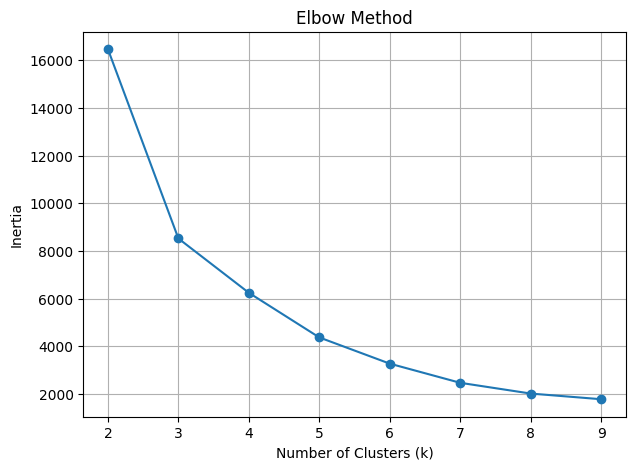

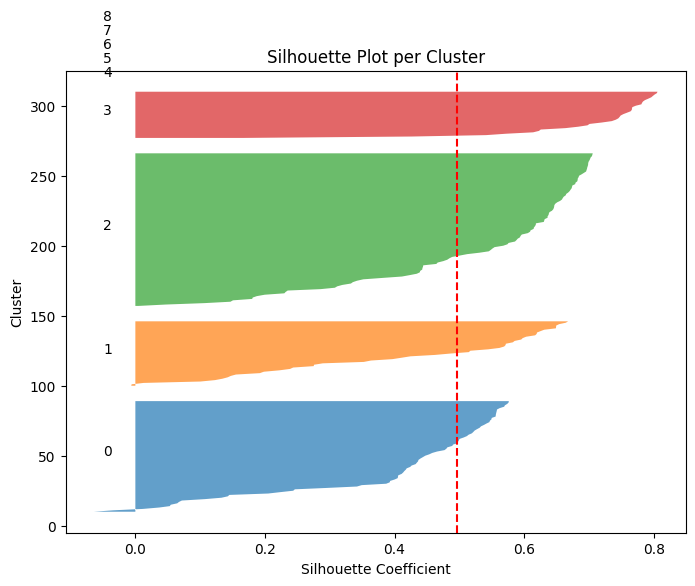


Sample hasil clustering:
      GeoAreaName  Cluster
0     Afghanistan        2
1          Africa        1
2         Albania        1
3         Algeria        0
4  American Samoa        0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.preprocessing import StandardScaler

# =============== 1. Mean Pooling Embedding (271, 23, 128) → (271, 128) ===============
final_embeddings = embedding.mean(axis=1)   # jika embedding = model.encode(data)

# (Opsional) Scaling sebelum clustering (umumnya meningkatkan stabilitas KMeans)
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(final_embeddings)

# =============== 2. K-Means Clustering ===============
k = 4  # atau pilih jumlah klaster sesuai kebutuhan
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(scaled_embeddings)

print("Clustering selesai.")
print("Jumlah cluster:", k)

# =============== 3. Evaluasi Clustering ===============

# Silhouette Score
sil_score = silhouette_score(scaled_embeddings, labels)
print("\nSilhouette Score:", sil_score)

# Calinski–Harabasz
ch_score = calinski_harabasz_score(scaled_embeddings, labels)
print("Calinski-Harabasz Score:", ch_score)

# Davies–Bouldin
db_score = davies_bouldin_score(scaled_embeddings, labels)
print("Davies-Bouldin Score:", db_score)

# =============== 4. Elbow Method ===============
inertia_list = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled_embeddings)
    inertia_list.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# =============== 5. Silhouette Plot per Cluster ===============
sil_values = silhouette_samples(scaled_embeddings, labels)

plt.figure(figsize=(8, 6))
y_lower = 10

for i in range(k):
    ith_sil_vals = sil_values[labels == i]
    ith_sil_vals.sort()

    size_i = ith_sil_vals.shape[0]
    y_upper = y_lower + size_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_sil_vals,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=sil_score, color="red", linestyle="--")
plt.title("Silhouette Plot per Cluster")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.show()

# =============== 6. Buat DataFrame Hasilnya ===============
cluster_result = pd.DataFrame({
    "GeoAreaName": df["GeoAreaName"],
    "Cluster": labels
})

print("\nSample hasil clustering:")
print(cluster_result.head())


--2025-11-19 07:36:22--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.92.251.233, 52.92.248.129, 52.218.246.67, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.92.251.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘world.zip’

world.zip           100%[===================>] 209.94K  1.00MB/s    in 0.2s    

2025-11-19 07:36:23 (1.00 MB/s) - ‘world.zip’ saved [214976/214976]

Archive:  world.zip
  inflating: world_map/ne_110m_admin_0_countries.README.html  
 extracting: world_map/ne_110m_admin_0_countries.VERSION.txt  
 extracting: world_map/ne_110m_admin_0_countries.cpg  
  inflating: world_map/ne_110m_admin_0_countries.dbf  
  inflating: world_map/ne_110m_admin_0_countries.prj  
  inflating: world_map/ne_110m_admin_0_countries.shp  
  inflating: world_map/ne_110m_ad

<Figure size 2200x1200 with 0 Axes>

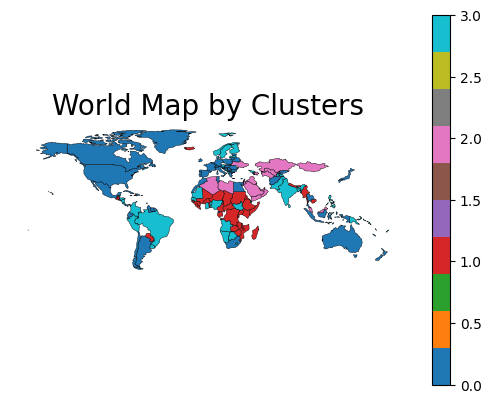

In [ ]:
!pip install geopandas
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip -O world.zip
!unzip -o world.zip -d world_map
!wget -q https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
!unzip -o ne_110m_admin_0_countries.zip -d ne_countries


import geopandas as gpd
import matplotlib.pyplot as plt

import geopandas as gpd
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load world shapefile Natural Earth ===
world = gpd.read_file("ne_countries/ne_110m_admin_0_countries.shp")

# Normalisasi nama negara
world['name'] = world['NAME_EN'].str.strip()

# === 2. Data hasil cluster Anda ===
# cluster_df berisi: Country | Cluster
# Pastikan memakai kolom yang sama
cluster_df.columns = ['Country', 'Cluster']

# Normalisasi nama negara agar mudah dicocokkan
cluster_df['Country_clean'] = cluster_df['Country'].str.strip()

# === 3. Banyak nama pada GeoAreaName adalah region, bukan negara ===
# Jadi kita cocokkan hanya negara yg valid saja
valid_countries = set(world['name'])
cluster_df_valid = cluster_df[cluster_df['Country_clean'].isin(valid_countries)]

print("Jumlah negara valid yg bisa dipetakan:", len(cluster_df_valid))

# === 4. Merge shapefile + cluster ===
world_clustered = world.merge(
    cluster_df_valid,
    left_on='name',
    right_on='Country_clean',
    how='left'
)

# === 5. Plot peta global hasil klaster ===
plt.figure(figsize=(22, 12))
world_clustered.plot(column='Cluster', cmap='tab10', legend=True, linewidth=0.3, edgecolor='black')
plt.title("World Map by Clusters", fontsize=20)
plt.axis('off')
plt.show()

